# 06 Augmentation BatchNorm

In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Scikit-learn per preprocessing e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Impostazioni
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

import os, urllib.request

# GitHub Release URL for pretrained weights
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Device: cuda
CUDA disponibile: True


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Training set: (60000, 28, 28)
Test set: (10000, 28, 28)

Range valori pixel: [0, 255]
Classi: [0 1 2 3 4 5 6 7 8 9]


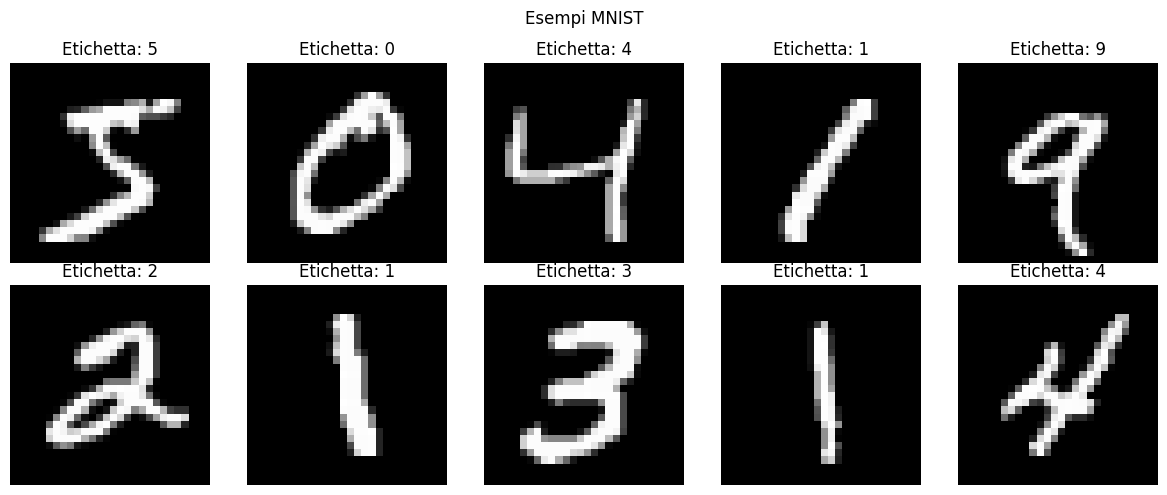

In [2]:
# Caricamento MNIST da torchvision
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

X_train = mnist_train.data.numpy()  # (60000, 28, 28)
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nRange valori pixel: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {np.unique(y_train)}")

# Visualizzazione esempi
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Etichetta: {y_train[i]}")
    ax.axis('off')
plt.suptitle('Esempi MNIST')
plt.tight_layout()
plt.show()

In [3]:
# Flatten: da (28, 28) a (784,)
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

print(f"Shape dopo flatten:")
print(f"  Training: {X_train_flat.shape}")
print(f"  Test: {X_test_flat.shape}")

# Normalizzazione
X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_flat / 255.0

print(f"\nRange dopo normalizzazione: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Shape dopo flatten:
  Training: (60000, 784)
  Test: (10000, 784)

Range dopo normalizzazione: [0.00, 1.00]


### 5.4 Data Augmentation

**Data Augmentation** aumenta artificialmente il dataset applicando trasformazioni alle immagini:
- Rotazioni
- Traslazioni
- Zoom
- Flip

Questo aiuta il modello a generalizzare meglio.

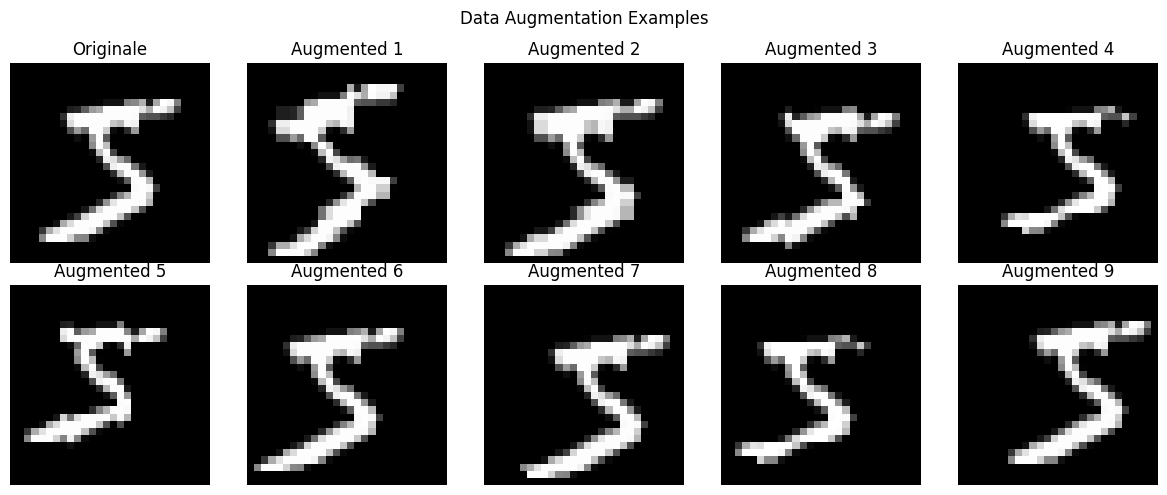

In [14]:
# Data Augmentation con torchvision.transforms
augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

# Visualizzazione augmentation
sample_img = X_train[0]  # (28, 28) numpy array

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Originale')
axes[0].axis('off')

# Genera 9 versioni augmented
sample_tensor = torch.from_numpy(sample_img).unsqueeze(0).to(torch.uint8)  # (1, 28, 28)
for i in range(1, 10):
    augmented = augmentation_transforms(sample_tensor)
    axes[i].imshow(augmented.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples')
plt.tight_layout()
plt.show()

### 5.5 Batch Normalization

**Batch Normalization** normalizza gli input di ogni layer, stabilizzando e accelerando il training.

In [15]:
# Modello con Batch Normalization
model_bn = nn.Sequential(
    nn.Linear(784, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 10)
).to(device)

print(model_bn)
total_params = sum(p.numel() for p in model_bn.parameters())
print(f"Total params: {total_params:,}")

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=64, out_features=10, bias=True)
)
Total params: 109,770
